In [2]:
#Imports
import torch
import torchvision
import torch.nn as nn
from torchsummary import summary

import torch.nn.functional as F
import matplotlib.pyplot as plt

##MOBILENETV2


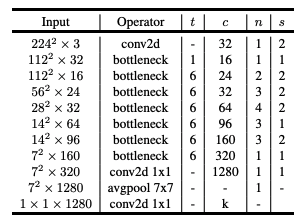

In [3]:
class LinearBottleNeck(nn.Module):
  def __init__(self,input_channel,out, expansion_factor=6, strides=2):
    super().__init__() 
    self.input_channel=input_channel
    self.expansion_factor = expansion_factor
    self.out = out
    self.add = True if input_channel == out and strides == 2 else False   
    mid=self.expansion_factor*self.input_channel
    self.conv1 = nn.Conv2d(in_channels=self.input_channel,out_channels=mid,kernel_size=1,stride=1,padding=0)
    self.bn1 = nn.BatchNorm2d(mid)
    self.dwconv = nn.Conv2d(mid, mid,3,strides,1, groups=mid)
    self.bn2 = nn.BatchNorm2d(mid)
    self.conv3=nn.Conv2d(mid,out,kernel_size=1,stride=1,padding=0)
    self.bn3 = nn.BatchNorm2d(out)

   
  def forward(self,input):
      
      x = self.conv1(input)
      x = F.relu(self.bn1(x))
      x = self.dwconv(x)
      x = F.relu(self.bn2(x)) 
      output = self.bn3(self.conv3(x))
      if self.add:
        output = torch.add(x,input)
     
      return output



architecture = [
# Input
{"input":[224, 3],"exp_rate":None,"out":32, "n":1, "s":2},
# Bottlenecks
{"input":[112, 32],"exp_rate":1,"out":16, "n":1, "s":1},
{"input":[112, 16],"exp_rate":6,"out":24, "n":2, "s":2},
{"input":[56, 24],"exp_rate":6,"out":32, "n":3, "s":2},
{"input":[28, 32],"exp_rate":6,"out":64, "n":4, "s":2},
{"input":[14, 64],"exp_rate":6,"out":96, "n":3, "s":1},
{"input":[14, 96],"exp_rate":6,"out":160, "n":3, "s":2},
{"input":[7, 160],"exp_rate":6,"out":320, "n":1, "s":1},
{"input":[7, 320],"exp_rate":None,"out":1280, "n":1, "s":1},
# AveragePool2D
{"input":[7, 1280],"exp_rate":None,"out":None, "n":1, "s":None},
# Output Conv
{"input":[1, 1280],"exp_rate":None,"out":1000, "n":None, "s":None},
]

layers = []
conv = architecture[0]
for _ in range(conv["n"]):
    layers.append(nn.Conv2d(conv["input"][1],conv["out"], kernel_size=3,stride=conv["s"], padding=1))

bottlenecks=architecture[1:-3]

for bottleneck in bottlenecks:
    for i in range(bottleneck["n"]):
        
        if bottleneck["n"]==1 :

          layers.append(LinearBottleNeck(
                  input_channel=bottleneck['input'][1],
                  out=bottleneck['out'],
                  expansion_factor=bottleneck["exp_rate"],
                  strides=bottleneck["s"]
                  ))
        if  bottleneck["n"]>1 and i!=bottleneck["n"]-1:
          layers.append(LinearBottleNeck(
                  input_channel=bottleneck['input'][1],
                  out=bottleneck['input'][1],
                  expansion_factor=bottleneck["exp_rate"],
                  strides=1
                  ))
        if  bottleneck["n"]>1 and i==bottleneck["n"]-1:
          layers.append(LinearBottleNeck(
                  input_channel=bottleneck['input'][1],
                  out=bottleneck['out'],
                  expansion_factor=bottleneck["exp_rate"],
                  strides=bottleneck["s"]
                  ))


conv_after_neck = architecture[-3]

for _ in range(conv_after_neck["n"]):
    layers.append(nn.Conv2d(conv_after_neck["input"][1],conv_after_neck["out"], kernel_size=1, stride=conv_after_neck["s"], padding=0)
    )
avgpool = architecture[-2]

for _ in range(avgpool["n"]):
    layers.append(nn.AdaptiveAvgPool2d((1,1)))

last_layer = architecture[-1]
layers.append(nn.Flatten())
layers.append( 
              nn.Linear(1280, last_layer["out"]))
mobilenetv2 =nn.Sequential(*layers)
input_sample = torch.rand((1, 3, 224, 224))
out = mobilenetv2(input_sample)


In [5]:
print(out.shape)

torch.Size([1, 1000])
